# Temporal variation in footfall
### Really need to do this after infilling missing data

Footfall levels vary throughout the year. This can be observed by plotting:
* The total footfall in each week
* The total footfall in each month
* The total footfall in each year 

Also, look at whether temporal trends change over time:
* E.g. the proportion of footfall occuring in different portions of the day

### Code initialisation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np

### Define functions

In [181]:
def make_file (hours_wanted, file):
    #file = file[file.LocationName.str.contains(LocationName) == True]
    day = pd.DataFrame(file, columns = ['Day', 'Month','Year', 'Hour', 'InCount', 'Day_yr'])
    day = split_day(day, hours_wanted)
    del day['Hour']
    day = day.groupby(['Day','Month', 'Year', 'Day_yr'], as_index=False).sum()    
    day['Day_yr'] = day['Day_yr'].apply(lambda x: x.split('/')[1]) 
    day = pd.DataFrame(day, columns = ['Day_yr', 'InCount'])
    day['datetime'] = pd.to_datetime(day['Day_yr'], format = '%d-%b-%Y')
    day = day.sort_values(by = 'datetime', ascending=[1])
    del day['datetime']
    day = day.reset_index(drop = True)
    return(day)

# Function to count the number of footfall counts within a certain time period
def counts_by_hours_of_day(sensor_df, hours_wanted, time_period):
    # Keep just the rows from the hours we are interested in 
    filtered_sensor_data = sensor_df.loc[sensor_df['hour'].isin(hours_wanted)].copy()
    # Create a datetime column
    filtered_sensor_data['datetime'] = pd.to_datetime(filtered_sensor_data[['year', 'month', 'day']])
    # Find the number of counts between these hours on each day
    counts_df = filtered_sensor_data.groupby(['datetime'], as_index=False).sum()    
    # Formatting
    counts_df = counts_df.sort_values(by = 'datetime', ascending=[1])
    counts_df = counts_df.reset_index(drop = True)
    counts_df = counts_df[['datetime', 'hourly_counts']]
    # Rename column t distinguish it from other timeslices
    counts_df.rename(columns={"hourly_counts": time_period}, inplace = True)
    return counts_df

# Function to make ticks for plotting
def make_ticks (file):
    t = file.iloc[:,0]
    t = t.dt.strftime('%Y')
    ticks = list(t.values.flatten())
    return ticks 

# Function to make scatter plot of footfall counts  
def make_plot (df, ax, time_of_day_column, time_of_day_str):
    # Scatter plot
    ax.scatter(df.index, df[time_of_day_column], s=6)
    # Fit and plot the best fit line
    fit = np.polyfit(df.index, df[time_of_day_column], deg=1)
    ax.plot(df.index, fit[0] * df.index + fit[1], color='red')
    # Set title and labels
    ax.set_title('% of footfall in {} '.format(time_of_day_str))
    ax.set_ylabel('Percentage footfall')
    ticks = make_ticks(df)
    ax.set_xticks(result.index)  
    ax.set_xticklabels(ticks, rotation=70)
    ax.locator_params(nbins=10, axis='x') 

# Function to add week number that starts always on 1st January, so is consistent between years
def add_custom_week_no(df):
    years = df['year'].unique()
    ls = []
    for year in years:
        this_year = df[df['year']==year].copy()
        year_start = this_year['datetime'].reset_index(drop =True)[0].replace(month=1, day=1, hour = 0)
        ls.extend((((this_year.datetime - year_start).dt.days/7) + 1).astype(int))
    return ls


### Read in data and add necessary columns

In [186]:
sensor_data = pd.read_csv("../Cleaned_data/single_sensor_locations.csv")
sensor_data['datetime']= pd.to_datetime(sensor_data['datetime'])
sensor_data['week_of_year'] = sensor_data['datetime'].dt.isocalendar().week
sensor_data['week_of_year_custom'] = add_custom_week_no(sensor_data)
sensor_data['weekday'] = sensor_data['datetime'].dt.strftime("%a")

### Group the data by various time based metrics

In [4]:
day_of_week = sensor_data.groupby(['weekday'])['hourly_counts'].sum()
day_of_week = day_of_week[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']]
hour_of_day = sensor_data.groupby(['hour'])['hourly_counts'].sum()
week_of_year = sensor_data.groupby(['week_of_year'])['hourly_counts'].sum()
month_of_year = sensor_data.groupby(['month'])['hourly_counts'].sum()
year = sensor_data.groupby(['year'])['hourly_counts'].sum()
ls_of_time_metrics = [hour_of_day, day_of_week, week_of_year, month_of_year, year]

### Plot variation over time metrics

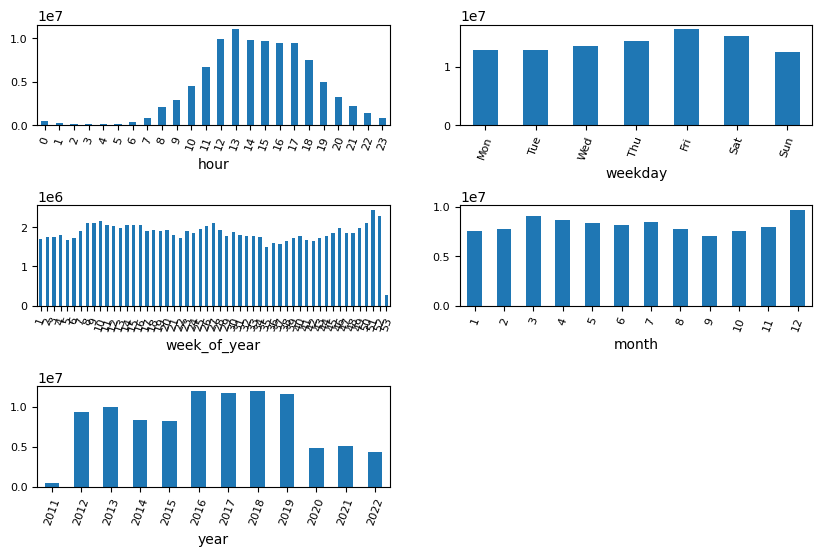

In [5]:
fig, axs = plt.subplots(3, 2, figsize = (10,6))
plt.subplots_adjust(hspace=0.8)
for i, ax in enumerate(axs.flat):
    if i <5:
        ls_of_time_metrics[i].plot.bar(ax=ax, rot=70, fontsize = 8)   
    if i ==5:
        ax.remove()

### Make the same plots using data for just one sensor
Currently some sensors won't have data for certain years etc, so doing it overall all sensors not going to give complete results

In [ ]:
### Filter for just one sensor
sensor1 = sensor_data[sensor_data.sensor_id ==1].copy()

In [6]:
day_of_week = sensor1.groupby(['weekday'])['hourly_counts'].sum()
day_of_week = day_of_week[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']]
hour_of_day = sensor1.groupby(['hour'])['hourly_counts'].sum()
week_of_year = sensor1.groupby(['week_of_year'])['hourly_counts'].sum()
month_of_year = sensor1.groupby(['month'])['hourly_counts'].sum()
year = sensor1.groupby(['year'])['hourly_counts'].sum()

ls_of_time_metrics = [hour_of_day, day_of_week, week_of_year, month_of_year, year]

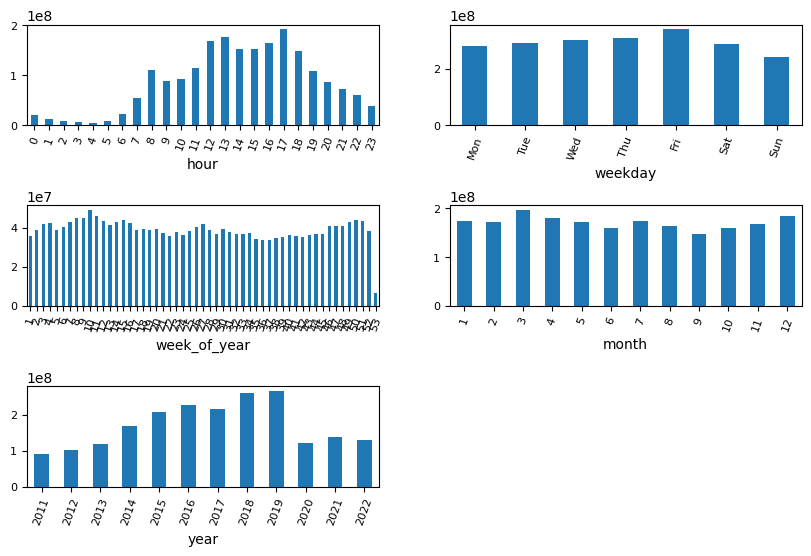

In [7]:
fig, axs = plt.subplots(3, 2, figsize = (10,6))
plt.subplots_adjust(hspace=0.8)
for i, ax in enumerate(axs.flat):
    if i <5:
        ls_of_time_metrics[i].plot.bar(ax=ax, rot=70, fontsize = 8)   
    if i ==5:
        ax.remove()

## Count the number of hourly footfall values at different time metrics
This checks for bias in where the missing data is.
Shows there is more data in later years (as expected) and slightly more data earlier in the year (not sure why

In [8]:
day_of_week = sensor_data.groupby(['weekday'])['hourly_counts'].count()
day_of_week = day_of_week[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']]
hour_of_day = sensor_data.groupby(['hour'])['hourly_counts'].count()
week_of_year = sensor_data.groupby(['week_of_year'])['hourly_counts'].count()
month_of_year = sensor_data.groupby(['month'])['hourly_counts'].count()
year = sensor_data.groupby(['year'])['hourly_counts'].count()
ls_of_time_metrics = [hour_of_day, day_of_week, week_of_year, month_of_year, year]

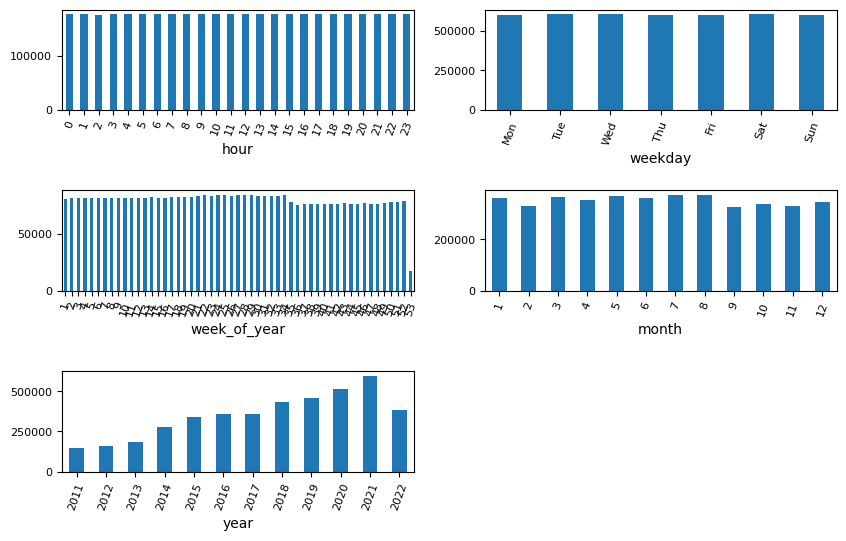

In [9]:
fig, axs = plt.subplots(3, 2, figsize = (10,6))
plt.subplots_adjust(hspace=0.8)
for i, ax in enumerate(axs.flat):
    if i <5:
        ls_of_time_metrics[i].plot.bar(ax=ax, rot=70, fontsize = 8)   
    if i ==5:
        ax.remove()

## Checking trends in proportion of footfall at different times of day

In [11]:
# Produce dataframes with the incount for the wholeday and for each of the three time segments
wholeday =counts_by_hours_of_day(sensor_data,list(range(0,24)), 'wholeday')
evening = counts_by_hours_of_day(sensor_data,list(range(18,21)),'evening')
daytime = counts_by_hours_of_day(sensor_data,list(range(8,18)), 'daytime')
nighttime = counts_by_hours_of_day(sensor_data,[21,22,23,24,0,1,2,3,4,5,6,7], 'nighttime')

In [19]:
# Join together to produce a dataframe with percentages of total daily footfall
# found in each of the time segments
counts_per_times_of_day = pd.concat([wholeday, daytime, evening, nighttime], axis=1)
# Drop duplicated datetime columns
counts_per_times_of_day = counts_per_times_of_day.loc[:,~counts_per_times_of_day.columns.duplicated()].copy()
counts_per_times_of_day['eve_percentage'] = counts_per_times_of_day['evening']/result['wholeday'] * 100
counts_per_times_of_day['nighttime_percentage'] = counts_per_times_of_day['nighttime']/result['wholeday'] * 100
counts_per_times_of_day['day_percentage'] = counts_per_times_of_day['daytime']/counts_per_times_of_day['wholeday'] * 100

### Plot

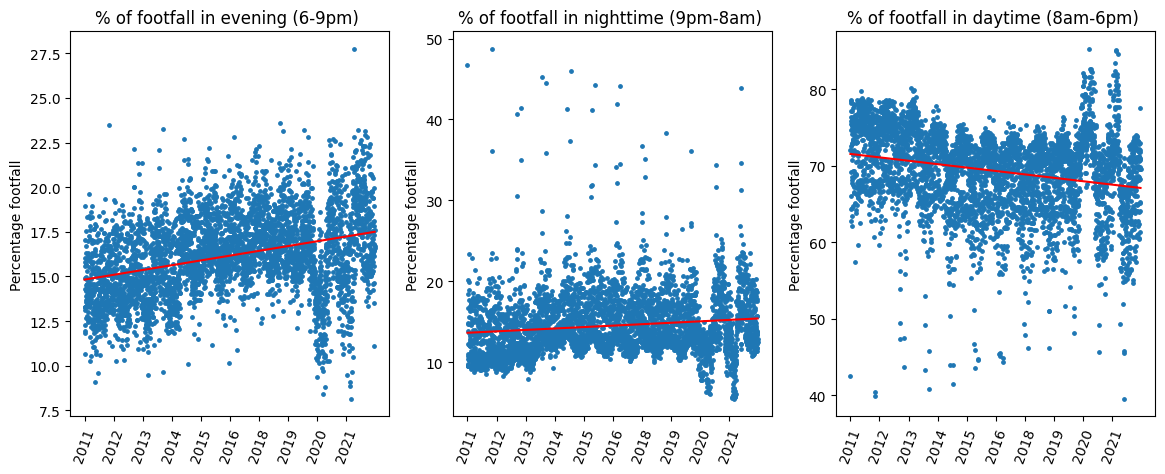

In [35]:
fig, axs = plt.subplots(1,3, figsize = (14,5))
make_plot(counts_per_times_of_day,axs[0], "eve_percentage", "evening (6-9pm)")
make_plot(counts_per_times_of_day,axs[1], "nighttime_percentage", "nighttime (9pm-8am)")
make_plot(counts_per_times_of_day,axs[2], "day_percentage", "daytime (8am-6pm)")

## Check for impact of Covid?
Would need to identify cameras which have data throughout this period

## Could do a similar analysis for trends in footfall in different parts of city?
But this would only work if enough cameras covering the same period of time